# Sistem za preporuku filmova zasnovan na kolaborativnom filtriranju

U ovom delu bavimo se izgradnjom sistema za preporuku koji je zasnovan na kolaborativnom filtriranju (eng. *collaborative filtering*). Ocene filmova se predviđaju na osnovu sličnosti među korisnicima (*user-based collaborative filtering*), odnosno među filmovima (*item-based collaborative filtering*). Preporučuju se oni filmovi za koje je predviđena ocena najviša. Učitajmo i pripremimo najpre neophodne podatke.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from ast import literal_eval
from scipy import sparse as sps
from sklearn.metrics import mean_squared_error
import math
from scipy.sparse.linalg import svds

import warnings; warnings.simplefilter('ignore')

In [2]:
ratings = pd.read_csv('the-movies-dataset/ratings_small.csv',usecols=['userId','movieId','rating'])
ratings.head()

,userId,movieId,rating
0,1,31,2.5
1,1,1029,3.0
2,1,1061,3.0
3,1,1129,2.0
4,1,1172,4.0


## 1. KNN pristup 

Koristićemo algoritam K najbližih suseda. Podaci treba da budu u formi $n x m$ matrice, gde je $m$ broj filmova a $n$ broj korisnika. Primenjujemo funkciju **pivot** na dataFrame *ratings*. Zatim popunjavamo nedostajuće podatke nulama. Tako dobijamo novi dataFrame koji ćemo nazvati *ratings_pivot*.

In [3]:
ratings_pivot = ratings.pivot(index='userId',columns='movieId',values='rating').fillna(0)
ratings_pivot.head(5)

movieId,1,2,3,4,5,6,7,8,9,10,...,161084,161155,161594,161830,161918,161944,162376,162542,162672,163949
userId,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [4]:
ratings_pivot.shape

(671, 9066)

Matrica *ratings_pivot* je dosta retka, pa ćemo iskoristiti funkciju **csr_matrix** iz **scipy.sparse** paketa.

In [5]:
ratings_matrix = sps.csr_matrix(ratings_pivot)
print(ratings_matrix.todense())

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [4. 0. 0. ... 0. 0. 0.]
 [5. 0. 0. ... 0. 0. 0.]]


Funkcija koja deli podatke na trening i test skup u datoj razmeri. Matrice treba da budu istih dimenzija, samo ocene drugačije raspodeljene.

In [6]:
def train_test_splitting(ratings_matrix, test_size): # test_size ocena ce biti u skupu za testiranje
    
    ratings = ratings_matrix.toarray()
    test = np.zeros(ratings.shape)
    train = ratings.copy()
    rows = (ratings != 0).sum(1)
    
    for user in range(ratings.shape[0]):
        count_per_user=int(np.ceil(test_size*rows[user]))
        test_ratings = np.random.choice(ratings[user, :].nonzero()[0], # 0 jer je nonzero primenjeno na vektor
                                        size=count_per_user,  # indeksi na kojima nisu 0
                                        replace=False)
        # u trening skup se upisuju 0 na izabranim pozicijama, a u skup za testiranje se upisuju elementi 
        train[user, test_ratings] = 0
        test[user, test_ratings] = ratings[user, test_ratings] 
        
    # provera da li su poznate ocene ili u jednom ili u drugom skupu
    assert(np.all((train * test) == 0)) 
    return sps.csr_matrix(train),sps.csr_matrix(test)

Definišemo funkciju koja računa gustinu popunjenosti matrice. Izdvajamo skupove za trening, validaciju i test.

**!!! Zbog predugog vremena izvršavanja i tehničkih problema redukujemo skupove podataka !!! **

In [7]:
ratings_reduced = ratings_matrix[:150, :350]
ratings_reduced

<150x350 sparse matrix of type '<class 'numpy.float64'>'
	with 2900 stored elements in Compressed Sparse Row format>

In [8]:
def density(ratings): 
    density = float(len(ratings.nonzero()[0]))
    density /= (ratings.shape[0] * ratings.shape[1])
    density *= 100
    return round(density,3)

In [9]:
train_validation, test = train_test_splitting(ratings_reduced, 0.2)
print('Non zero count - train_validation: ',train_validation.getnnz())
print('Density - train_validation: ',density(train_validation),'%')
print('Non zero count - test: ',test.getnnz())
print('Density - test: ',density(test),'%')

Non zero count - train_validation:  2254
Density - train_validation:  4.293 %
Non zero count - test:  646
Density - test:  1.23 %


Implementiramo KNN algoritam.

In [10]:
def k_nearest_neighbors(i, similarity_matrix, k=10):
   
    neighbors = []
    similarities = list(zip(similarity_matrix[i][:],range(similarity_matrix.shape[0])))
    similarities.sort(key = lambda x: x[0], reverse=True)
    for i in range(1,k+1):
        neighbors.append(similarities[i][1])
    
    return neighbors

### User-based kolaborativno filtriranje
Računamo matricu sličnosti između korisnika. Računamo kosinusno rastojanje.

In [33]:
def similarity_between_users(ratings, epsilon=1e-9):
    return cosine_similarity(ratings) + epsilon 

Previđanje ocene korisnika $u$ za film $i$ na osnovu formule:
$ r'_{ui} = \mu_u + \frac{\sum_{v \in N^k_i(u)}sim(u,v)(r_{vi}-\mu_v)}{\sum_{v \in N^k_i(u)}sim(u,v)} $

In [167]:
def user_based_prediction(u, i, users_similarity, ratings, k):
        
        neighbors = k_nearest_neighbors(u,users_similarity,k)
        rated_by_u = ratings[u].nonzero()[1]
        
        mu_u = 0
        
        for i in rated_by_u:
            mu_u += ratings[u, i]
        
        if len(rated_by_u) != 0:
            mu_u = mu_u / len(rated_by_u)
        
        
        sum1 = 0.0
        sum2 = 0.0
    
        for v in neighbors:
            
            rated_by_v = ratings[v].nonzero()[1]
            mu_v = 0
            
            if len(rated_by_v) != 0:
        
                for i in rated_by_v:
                    mu_v += ratings[v, i]
            
                mu_v = mu_v / len(rated_by_v)
                
            r_vi = ratings[v,i]
            sum1 += users_similarity[u][v]*(r_vi - mu_v)
            sum2 += users_similarity[u][v]
            
    
        return mu_u + sum1/sum2

In [133]:
def get_user_based_prediction(ratings, users_similarity, k = 10):
    predictions = np.zeros(ratings.shape)
    
    for u in range(ratings.shape[0]):
        for i in range(ratings.shape[1]):
            predictions[u,i] = user_based_prediction(u,i,users_similarity,ratings, k)
            
    return predictions
    
    

### Item-based kolaborativno filtriranje
Računamo matricu sličnosti između filmova. Računamo kosinusno rastojanje.

In [36]:
def similarity_between_movies(ratings, epsilon=1e-9):
    return cosine_similarity(ratings.T) + epsilon

Previđanje ocene korisnika $u$ za film $i$ na osnovu formule:
$ r'_{ui} = \mu_i + \frac{\sum_{j \in N^k_u(i)}sim(i,j)(r_{uj}-\mu_j)}{\sum_{j \in N^k_u(i)}sim(i,j)} $

In [166]:
def item_based_prediction(u, i, movies_similarity, ratings, k):
        
        neighbors = k_nearest_neighbors(i,movies_similarity,k)
        
        rated_i = ratings[:, i].nonzero()[0]
        
        mu_i = 0
        
        for u in rated_i:
            mu_i += ratings[u, i]
         
        if len(rated_i) != 0:
            mu_i = mu_i / len(rated_i)
        
        sum1 = 0.0
        sum2 = 0.0
    
        for j in neighbors:
            rated_j = ratings[:, j].nonzero()[0]
            mu_j = 0
            
            if len(rated_j) != 0:
        
                for u in rated_j:
                    mu_j += ratings[u, j]
            
                mu_j = mu_j / len(rated_j)

            r_uj = ratings[u,j]
            sum1 += movies_similarity[i][j]*(r_uj - mu_j)
            sum2 += movies_similarity[i][j]
            
    
        return mu_i + sum1/sum2

In [38]:
def get_item_based_prediction(ratings, movies_similarity, k = 10):
    predictions = np.zeros(ratings.shape)
    
    for u in range(ratings.shape[0]):
        for i in range(ratings.shape[1]):

            predictions[u,i] = item_based_prediction(u, i, movies_similarity, ratings, k)
            
    return predictions
    

### Određivanje vrednosti parametra $k$ na validacionom skupu i evaluacija na test skupu

Funkcija **selection** deli skup podataka na skup za treniranje i skup za validaciju, a zatim iz skupa zadatih $k$-ova određuje onu vrednost parametra $k$ za koju je greška predviđanja na validacionom skupu najmanja. Vraća matricu predviđanja za najbolje $k$, obučenu koristeći sve prosleđene podatke (uniju trening i validacionog skupa), kao i skup grešaka na validacionom skupu u zavisnosti od *k* radi vizualizacije.

In [162]:
ks = [1,5,10,20,25,30,35,40,45]

In [168]:
def selection(train_validation, ks, option):
    
    train, validation = train_test_splitting(train_validation, 0.2)
    errors = np.array([])
    
    if option == 'user':
        
        similarity = similarity_between_users(train)
        
        for k in ks:
            predictions = get_user_based_prediction(train, similarity, k)
            error = np.sqrt(mean_squared_error(validation.toarray()[validation.nonzero()],predictions[validation.nonzero()]))
        
            errors = np.append(errors, error)
    else:
        similarity = similarity_between_movies(train)
        
        for k in ks:
            predictions = get_item_based_prediction(train, similarity, k)
            error = np.sqrt(mean_squared_error(validation.toarray()[validation.nonzero()],predictions[validation.nonzero()]))
        
            errors = np.append(errors, error)
        
    k_best = ks[np.argmin(errors)]
    
    if option == 'user':
        similarity = similarity_between_users(train_validation)
        return errors, get_user_based_prediction(train_validation, similarity, k_best)
    else:
        similarity = similarity_between_movies(train_validation)
        return errors, get_item_based_prediction(train_validation, similarity, k_best)
    

Nalazimo najbolje *k* za user-based KNN, ono za koje je greška predviđanja na validacionom skupu najmanja.

In [169]:
errors_user, predictions_user = selection(train_validation, ks, 'user')

In [170]:
print('User-based best k: ', ks[np.argmin(errors_user)])

User-based best k:  40


Nalazimo najbolje *k* za item-based KNN, ono za koje je greška predviđanja na validacionom skupu najmanja.

In [171]:
errors_item, predictions_item = selection(train_validation, ks, 'item')

In [172]:
print('Item-based best k: ', ks[np.argmin(errors_item)])

Item-based best k:  35


Vizualizujemo zavisnost greške predviđanja (RMSE) na validacionom skupu od parametra $k$.

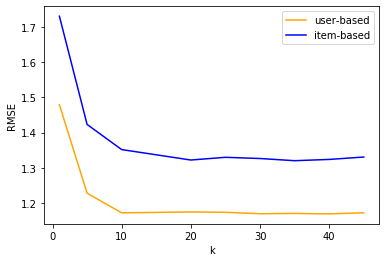

In [173]:
plt.plot(ks, errors_user, color = 'orange', label = 'user-based')
plt.plot(ks, errors_item, color = 'blue', label = 'item-based')
plt.xlabel('k')
plt.ylabel('RMSE')
plt.legend(loc='best')
plt.show()

In [175]:
error_train_user = np.sqrt(mean_squared_error(train_validation.toarray()[train_validation.nonzero()],predictions_user[train_validation.nonzero()]))
error_train_item = np.sqrt(mean_squared_error(train_validation.toarray()[train_validation.nonzero()],predictions_item[train_validation.nonzero()]))
print('User-based train RMSE:', error_train_user)
print('Item-based train RMSE:', error_train_item)

User-based train RMSE: 0.9629265611369424
Item-based train RMSE: 0.9169584553428691


Konačno, vršimo evaluaciju na test skupu (koji nije korišćen u obučavanju).

In [174]:
error_test_user = np.sqrt(mean_squared_error(test.toarray()[test.nonzero()],predictions_user[test.nonzero()]))
error_test_item = np.sqrt(mean_squared_error(test.toarray()[test.nonzero()],predictions_item[test.nonzero()]))
print('User-based test RMSE:', error_test_user)
print('Item-based test RMSE:', error_test_item)

User-based test RMSE: 1.1124499299251787
Item-based test RMSE: 1.1935628286428064


## 2. Singularna dekompozicija matrica
Još jedan pristup zasnovan na kolaborativnom filtriranju jeste korišćenjem singularne dekompozicije matrica (SVD). Kako je matrica ocena $R$ retka (jedan korisnik je ocenio samo mali deo filmova), ona se može dekomponovati kao $R = M\Sigma U^T$, gde je $U$ matrica korisnika, $M$ matrica filmova, a $\Sigma$ je dijagonalna matrica. Jednostavnosti radi, možemo posmatrati jednakost bez dijagonalne matrice, odnosno samo $R = MU^T$.
Označimo sa $r_{ui}$ ocenu korisnika $u$ za film $i$, sa $p_u$ red matrice $M$ koji se odnosi na korisnika $u$ i sa $q_i$ kolonu matrice $U^T$ koja se odnosi na film $i$. Dobijamo jednakost na osnovu koje se vrši predviđanje ocena: $$ r_{ui}= p_uq_i$$ 

In [91]:
M, sigma, Ut = svds(train, k = 4)

In [92]:
sigma = np.diag(sigma)
sigma

array([[136.46752812,   0.        ,   0.        ,   0.        ],
       [  0.        , 168.88852453,   0.        ,   0.        ],
       [  0.        ,   0.        , 198.21038571,   0.        ],
       [  0.        ,   0.        ,   0.        , 415.29936374]])

In [ ]:
predictions_svd_matrix = np.dot(np.dot(M,sigma),Ut)

In [93]:
train_predictions_svd = list(predictions_svd_matrix[train.nonzero()].flatten())
len(train_predictions_svd)

79748

In [94]:
train_ratings_svd = []
rows,cols = train.nonzero()

for row,col in zip(rows,cols):
    train_ratings_svd.append(train[row,col])

len(train_ratings_svd)

79748

In [95]:
rmse_train_svd = np.sqrt(mean_squared_error(train_ratings_svd,train_predictions_svd))
print('Singular Value Decomposition train RMSE: ',rmse_train_svd)

Singular Value Decomposition train RMSE:  2.956196813823273


In [96]:
test_predictions_svd = list(predictions_svd_matrix[test.nonzero()].flatten())
len(test_predictions_svd)

20256

In [97]:
test_ratings_svd = []
rows,cols = test.nonzero()

for row,col in zip(rows,cols):
    test_ratings_svd.append(test[row,col])

len(test_ratings_svd)

20256

In [99]:
rmse_test_svd = np.sqrt(mean_squared_error(test_ratings_svd,test_predictions_svd))
print('Singular Value Decomposition test RMSE: ',rmse_test_svd)

Singular Value Decomposition test RMSE:  3.049447802265524


## 3. Metod latentnih faktora

Singularna dekompozicije (SVD) matrice ocena može biti skupa jer je matrica retka. Takođe, SVD ne radi kada podaci nedostaju. To umanjuje performanse. Sledeći pristup predviđanja ocena će se sastojati u pronalaženju ovih fakora tako da se minimizuje regularizovana kvadratna greška na trening skupu: $$min_{q^*,p^*,b^*} \sum_{(u,i) \in s} (r_{ui} - q^T_ip_u)^2 + \lambda(||q_i||^2 + ||p_u||^2)$$

Ovo radimo koristeći stohastički gradijentni spust. Najpre inicijalizujemo tražene matrice nasumičnim vrednostima iz unifomne raspodele. Zatim za svaki par (korisnik-film, ocena) iz trening skupa ažuriramo parametre prema grešci između stvarne i predviđene ocene. Na primer, faktor korisnika $p_u$ se ažurira na sledeći način:
$$ p_u = p_u + \alpha*((r_{ui} - r'_{ui})q_i - \lambda p_u)$$

Jednakost na osnovu koje se vrši predviđanje ocena: $$ r_{ui}= p_uq_i$$ 

In [48]:
# RMSE za SGD
def RMSE(data, Q, P):
    I = data != 0  # indikatorska funkcija o ocenjenim filmovima
    ME = I * (data - np.dot(P, Q.T))  # greska izmedju stvarnih i predvidjenih vrednosti
    MSE = ME**2  
    return np.sqrt(np.sum(MSE)/np.sum(I)) 

In [49]:
# f je broj latentnih (skrivenih) faktora
# l je regularizacioni parametar
# alpha je learning rate (brzina ucenja)

def stohastic_gradient_descent(train, test, f, number_of_epochs, l, alpha):
    
    users,items = train.nonzero()    
    P = np.random.rand(train.shape[0], f) # latentni faktori za korisnike
    Q = np.random.rand(train.shape[1], f) # latentni faktori za filmove
    
    train_errors = []
    test_errors = []
    
    for epoch in range(number_of_epochs):
        for u, i in zip(users, items):
            diff = train[u, i] - np.dot(P[u,:], Q[i,:].T) # razlika izmedju prave i predvidjene vrednosti
            # azuriranje faktora za korisnike
            P[u, :] += alpha * (diff * Q[i,:] - l * P[u,:])
            #azuriranje faktora za filmove
            Q[i, :] += alpha * (diff * P[u,:] - l * Q[i, :])
        train_errors.append(RMSE(train.toarray(),Q,P))
        test_errors.append(RMSE(test.toarray(),Q,P))
    
    return train_errors, test_errors


In [47]:
def predictions(P, Q):
    return np.dot(P.T, Q)

### Nalaženje najbolje konfiguracije i evaluacija na test skupu

 Izdvajamo trening i validacioni skup. Treba naći optimalne vrednosti svih hiperparametara, tj. one kojima se minimizuje RMSE na validacionom skupu. U te svrhe, definišemo funkciju **best_configuration**.

In [55]:
train, validation = train_test_splitting(train_validation, 0.2)

In [86]:
number_of_epochs = 10
configs = {}
configs['lambda'] = [10**(-i) for i in np.linspace(1,10,10)]
configs['f'] = [2*i for i in range(1,11)]
configs['alpha'] = [10**(-i) for i in np.linspace(1,10,10)]


In [57]:
def best_configuration(train, validation, configs):
    
    best_l = None
    best_f = None
    best_a = None
    min_error = float('inf')
  
    for l in configs['lambda']:
        for f in configs['f']:
            for a in configs['alpha']:
                train_errors, validation_errors = stohastic_gradient_descent(train, validation, f, number_of_epochs, l, a)
                error = validation_errors[-1]
                if error < min_error:
                    min_error = error
                    best_l = l
                    best_f = f
                    best_a = a
                    
    return best_l, best_f, best_a, min_error
                

In [58]:
best_l, best_f, best_a, min_error = best_configuration(train, validation, configs)
print('Best parameters: ')
print('lambda =', best_l)
print('f = ', best_f)
print('alpha = ', best_a)

Best parameters: 
lambda = 0.01
f =  12
alpha =  0.01


Pogledajmo kako se smanjuje RMSE na trening i validacionom skupu u zavisnosti od broja epoha, sa pronađenim optimalnim parametrima.

In [87]:
train_errors, validation_errors = stohastic_gradient_descent(train, validation, best_f, number_of_epochs, best_l, best_a)

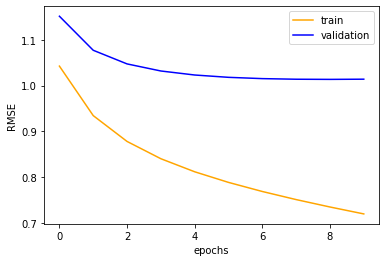

In [88]:
plt.plot(train_errors, color="orange", label='train')
plt.plot(validation_errors, color="blue", label='validation')
plt.xlabel('epochs')
plt.ylabel('RMSE')
plt.legend(loc = 'best')
plt.show()

Konačno, izvršimo obučavanje nad podacima iz unije trening i validacionog skupa i evaluiramo na test skupu.

In [89]:
train_errors, test_errors = stohastic_gradient_descent(train_validation, test, best_f, number_of_epochs, best_l, best_a)
train_rmse = train_errors[-1]
test_rmse = test_errors[-1]
print('Training RMSE: ', train_rmse)
print('Test RMSE: ', test_rmse)

Training RMSE:  0.7220302894150963
Test RMSE:  0.992353077059672
